In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [3]:
ls gdrive

'My Drive'/


In [0]:
import os
os.chdir("/content/gdrive/My Drive/CS598")

# Copy data to local dir

In [0]:
# !mkdir /dataCS5981
!cp -r -n RADVESS/ /data



In [0]:
!cp -r -n AudioData/ /data

In [0]:
!cp -r -n TESS/ /data

In [10]:
ls /data

Actor_01/  Actor_07/  Actor_13/  Actor_19/  AudioData/
Actor_02/  Actor_08/  Actor_14/  Actor_20/  Audio_Speech_Actors_01-24.zip
Actor_03/  Actor_09/  Actor_15/  Actor_21/  RADVESS/
Actor_04/  Actor_10/  Actor_16/  Actor_22/  TESS/
Actor_05/  Actor_11/  Actor_17/  Actor_23/
Actor_06/  Actor_12/  Actor_18/  Actor_24/


In [11]:
!pip3 install torch torchvision
!pip3 install librosa
!pip3 install hmmlearn

     |████████████████████████████████| 368kB 6.2MB/s 


In [12]:
!pip3 install torch torchvision torchsummary

Make sure that pytorch is installed and works with GPU:

In [13]:
import torch
a = torch.Tensor([1]).cuda()
print(a)


tensor([1.], device='cuda:0')


In [0]:
import numpy as np
import scipy.linalg as lg
from scipy import signal
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import scipy
import sys
import os
from random import shuffle
import librosa
import librosa.display
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
from hmmlearn import hmm
from collections import Counter
import matplotlib.ticker as mtick


In [15]:
torch.cuda.is_available()

True

In [0]:
data_names = []
data_labels1 = []
data_labels2 = []
data_labels3 = []
data_mfccs1 = []
data_mfccs2 = []
data_mfccs3 = []

In [0]:
emotionDict = {'happy': 0, 'sad': 1, 'angry': 2, 'fearful': 3}

for dirs in os.listdir('/data'):
    # If file is not directory, continue
    if os.path.isdir('/data/'+ dirs):
      files = os.listdir('/data/'+ dirs)
    else:
      continue
    if dirs[0:5] != 'Actor':
      continue
    for file in files:
        f = file.split('-')
        inEmotion = False
        # if int(f[6][:2]) % 2 == 1: 
        if(f[2]=='03'):
            data_labels1.append(emotionDict['happy'])
            inEmotion = True
        elif(f[2]=='04'):
            data_labels1.append(emotionDict['sad'])
            inEmotion = True
        elif(f[2]=='05'):
            data_labels1.append(emotionDict['angry'])
            inEmotion = True
        elif(f[2]=='06'):
            data_labels1.append(emotionDict['fearful'])
            inEmotion = True
        if inEmotion == True:
            data_names.append(file)
            # load data
            data, sample_rate = librosa.load('RADVESS/'+dirs+'/'+ file, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5) # data is 110250
            # get mfcc features
            mfccs = librosa.feature.mfcc(y=data.astype(dtype=float), sr=sample_rate, n_mfcc=13) # 13 x 216
            while mfccs.shape[1] < 216:
              mfcc = np.concatenate((mfccs, mfccs), axis=1)
              mfccs = mfcc[:,:216]
            data_mfccs1.append(mfccs)

In [0]:
for dirs in os.listdir('/data/AudioData/'):
  if os.path.isdir('/data/AudioData/'+ dirs):
    files = os.listdir('/data/AudioData/'+ dirs)
  else:
    continue
  for file in files:
    inEmotion = False
    if file[0] == 'h':
      data_labels2.append(emotionDict['happy'])
      inEmotion = True
    elif file[0] == 'a':
      data_labels2.append(emotionDict['angry'])
      inEmotion = True
    elif file[0] == 'f':
      data_labels2.append(emotionDict['fearful'])
      inEmotion = True
    elif file[0:2] == 'sa':
      data_labels2.append(emotionDict['sad'])
      inEmotion = True
    if inEmotion == True:
      data_names.append(file)
      # load data
      data, sample_rate = librosa.load('AudioData/'+dirs+'/'+ file, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5) # data is 110250
      # get mfcc features
      mfccs = librosa.feature.mfcc(y=data.astype(dtype=float), sr=sample_rate, n_mfcc=13) # 13 x 216
      while mfccs.shape[1] < 216:
        mfcc = np.concatenate((mfccs, mfccs), axis=1)
        mfccs = mfcc[:,:216]
      data_mfccs2.append(mfccs)
    

In [0]:
for dirs in os.listdir('/data/TESS/'):
  files = os.listdir('/data/TESS/' + dirs)
  for file in files:
    inEmotion = False
    f = file.split('_')
    f = f[2].split('.')
    if f[0] == 'happy':
      data_labels3.append(emotionDict['happy'])
      inEmotion = True
    elif f[0] == 'angry':
      data_labels3.append(emotionDict['angry'])
      inEmotion = True
    elif f[0] == 'fear':
      data_labels3.append(emotionDict['fearful'])
      inEmotion = True
    elif f[0] == 'sad':
      data_labels3.append(emotionDict['sad'])
      inEmotion = True
    if inEmotion == True:
      #data_names.append(file)
      # load data
      data, sample_rate = librosa.load('/data/TESS/'+dirs+'/'+ file, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5) # data is 110250
      # get mfcc features
      mfccs = librosa.feature.mfcc(y=data.astype(dtype=float), sr=sample_rate, n_mfcc=13) # 13 x 216
      while mfccs.shape[1] < 216:
        mfcc = np.concatenate((mfccs, mfccs), axis=1)
        mfccs = mfcc[:,:216]
      data_mfccs3.append(mfccs)

In [20]:
# Convert 2d mfcc features to 1d
features = data_mfccs1 + data_mfccs2 + data_mfccs3 # (216,)
# features = features.astype(dtype='double')
print(len(features), features[0].shape, len(data_names))

data_labels = data_labels1 + data_labels2 + data_labels3
print(len(data_labels))

2608 (13, 216) 1008
2608


In [0]:
def most_frequent(lst):
  data = Counter(lst)
  return data.most_common(1)[0][0]

In [0]:
def get_transition_left_right(n):
    trans = np.zeros((n,n))
    for i in range(n-1):
        trans[i][i] = 0.5
        trans[i][i+1] = 0.5
    trans[n-1][n-1] = 1
    return trans

In [23]:
featuresHMM = features 
data_labelsHMM = data_labels 
# shuffle data
rang = np.arange(0, len(featuresHMM))
shuffle(rang)
shuffled_featuresHMM = [featuresHMM[i] for i in rang]
print(shuffled_featuresHMM[0].shape)
shuffle_data_labelsHMM = [data_labelsHMM[i] for i in rang]
print(len(shuffled_featuresHMM), len(shuffle_data_labelsHMM))

totLen = len(shuffled_featuresHMM)
train_feature = shuffled_featuresHMM[0:int(totLen*0.8)]
train_label = shuffle_data_labelsHMM[0:int(totLen*0.8)]
test_feature = shuffled_featuresHMM[int(totLen*0.8):]
test_label = shuffle_data_labelsHMM[int(totLen*0.8):]

(13, 216)
2608 2608


2
trainData.shape (13, 216)


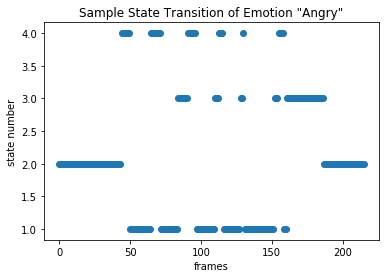

In [66]:
n_comp = 4

models = []
for classIdx in range(4):
  lr = hmm.GaussianHMM(n_components=n_comp, covariance_type="diag")
  lr.startprob_ = np.zeros(n_comp)
  lr.startprob_[0] = 1
  lr.transmat_ = get_transition_left_right(n_comp)
  # get each class's training data
  idxs = [i for i in range(len(train_label)) if train_label[i] == classIdx]
  trainSet = [train_feature[idx] for idx in idxs]
  print("len(trainSet)", len(trainSet))
  trainData = np.hstack(trainSet)
  lr.fit(trainData.T)
  models.append(lr)

acc = 0
predictions_hmm = []
acc_class = [0,0,0,0]
acc_class_total = [0,0,0,0]
for i in range(4):
  acc_class_total[i] = test_label.count(i)
print(acc_class_total)
for i in range(len(test_feature)):
  # get class test data
  testData = test_feature[i]
  scores = [(hmm.score(testData.T)) for hmm in models]
  estimated_class = np.argmax(scores)
  predictions_hmm.append(estimated_class)
  if estimated_class == test_label[i]:
    acc += 1
    acc_class[test_label[i]] += 1
accs.append(acc/len(test_feature))
print('acc ' + str(acc/len(test_feature)))
print(acc_class)

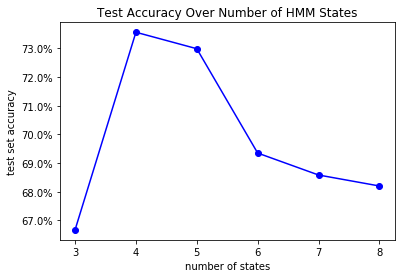

In [51]:
# for l_i, acc in enumerate(accs):
plt.plot(np.arange(3,9), accs, marker='o', color='b')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.xlabel('number of states')
plt.ylabel('test set accuracy')
plt.title('Test Accuracy Over Number of HMM States')
plt.show()

[52.23880597 82.57575758 81.88976378 68.21705426]


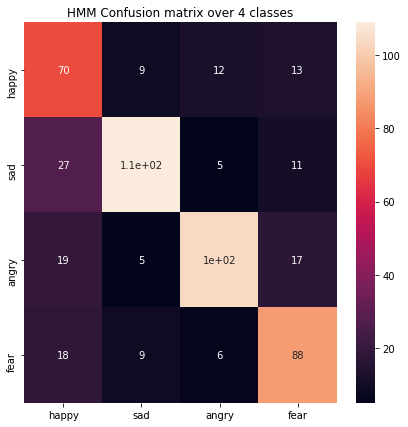

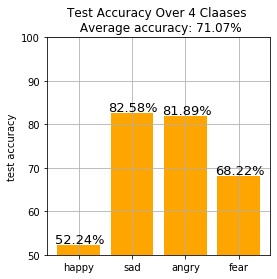

In [33]:
C = np.histogram2d(predictions_hmm, test_label, bins=4)[0]
my_xticks = ['happy','sad','angry','fear']
df_cm = pd.DataFrame(C, index=[i for i in my_xticks], columns=[i for i in my_xticks])
plt.figure(figsize = (7,7))
plt.title("HMM Confusion matrix over 4 classes")
sn.heatmap(df_cm, annot=True)

class_accuracy = 100 * np.divide(acc_class, acc_class_total)
print(class_accuracy)
f, ax = plt.subplots(figsize=(4,4))
x = np.arange(1,5)
idx = np.array([0,1,2,3])
ax.set_xticks(x)
ax.set_xticklabels(my_xticks)
for i in range(4):
  ax.text(i+0.56, class_accuracy[i].item()+0.4, str(format(class_accuracy[i].item(), ".2f")+"%"), fontsize=13)
ax.bar(x, class_accuracy, color='orange')
ax.set_ylim(bottom=50, top=100)
ax.set_ylabel('test accuracy')
ax.set_title('Test Accuracy Over 4 Claases \n Average accuracy: ' + str(format(acc/len(test_feature),".2%")))
ax.grid(True)
# ax.figure.savefig("test_acc.png")
plt.show()

In [0]:
# shuffle data
# z = list(zip(features, data_labels))
rang = np.arange(0, len(features))
shuffle(rang)
shuffled_features = [features[i] for i in rang]
shuffle_data_labels = [data_labels[i] for i in rang]

# split data into train and test set
totLen = len(features)
train_feature = shuffled_features[0:int(totLen*0.8)]
test_feature = shuffled_features[int(totLen*0.8):int(totLen*0.9)]
val_feature = shuffled_features[int(totLen*0.9):]

train_label = shuffle_data_labels[0:int(totLen*0.8)]
test_label = shuffle_data_labels[int(totLen*0.8):int(totLen*0.9)]
val_label = shuffle_data_labels[int(totLen*0.9):]
print(len(train_feature),len(test_feature),len(train_label),len(test_label),len(val_feature), len(val_label))
# Convert list to array
train_feature = np.rollaxis(np.dstack(train_feature),-1)
test_feature = np.rollaxis(np.dstack(test_feature),-1)
val_feature = np.rollaxis(np.dstack(val_feature),-1)
print((train_feature.shape), train_feature[0].shape, test_feature.shape, val_feature.shape)

2086 261 2086 261 261 261
(2086, 13, 216) (13, 216) (261, 13, 216) (261, 13, 216)


In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.utils.data
# import torchvision
# import torchvision.transforms as transforms

from torch.autograd import Variable
IS_GPU = True


In [0]:
class BaseNet(nn.Module):
    def __init__(self):
        super(BaseNet, self).__init__()
        # Add more conv layers with increasing output channels
        # Add normalization layers after conv layers (nn.BatchNorm2d)
        # Also experiment with kernel size in conv2d layers (say 3
        # inspired from VGGNet)
    
        self.conv_net = nn.Sequential(
            nn.Conv1d(13, 256, kernel_size=5, padding=2), # (216 + 2*2 - 1*(5-1) - 1)/1+1= 216
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3), # 216/3=72
            
            nn.Conv1d(256, 512, kernel_size=5, padding=2), # (216 + 2*2 - 1*(5-1) - 1)/1+1= 216
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3), # 72/3=24
            
            nn.Dropout(p=0.1),

            nn.Conv1d(512, 512, kernel_size=5, padding=2), # (216 + 2*2 - 1*(5-1) - 1)/1+1= 216
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3), # 24/3=8

            nn.Conv1d(512, 512, kernel_size=5, padding=2), # (216 + 2*2 - 1*(5-1) - 1)/1+1= 216
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2), # 8/2=4
            
            nn.Flatten(),
        )

        # Add more linear (fc) layers
        # Add normalization layers after linear and
        # experiment inserting them before or after ReLU (nn.BatchNorm1d)
        
        self.fc_net = nn.Sequential(
            # nn.Linear(4*1024, 2*1024),
            # nn.ReLU(inplace=True),
            # nn.BatchNorm1d(2*1024),

            # nn.Linear(2*256, 256),
            # nn.ReLU(inplace=True),
            # nn.BatchNorm1d(256),


            nn.Linear(512*4, 4),
            nn.BatchNorm1d(4),
            # nn.Softmax(),
        )

    def forward(self, x):
        x = self.conv_net(x)
        x = self.fc_net(x)
        return x

# Create an instance of the nn.module class defined above:
net = BaseNet()
net = net.float()
if IS_GPU:
    net = net.cuda()

In [0]:
from torchsummary import summary
summary(net, (13,216), 32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [32, 256, 216]          16,896
       BatchNorm1d-2             [32, 256, 216]             512
              ReLU-3             [32, 256, 216]               0
         MaxPool1d-4              [32, 256, 72]               0
            Conv1d-5              [32, 512, 72]         655,872
       BatchNorm1d-6              [32, 512, 72]           1,024
              ReLU-7              [32, 512, 72]               0
         MaxPool1d-8              [32, 512, 24]               0
           Dropout-9              [32, 512, 24]               0
           Conv1d-10              [32, 512, 24]       1,311,232
      BatchNorm1d-11              [32, 512, 24]           1,024
             ReLU-12              [32, 512, 24]               0
        MaxPool1d-13               [32, 512, 8]               0
           Conv1d-14               [32,

In [0]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()

# optimizer = optim.SGD(net.parameters(), lr=0.00001, momentum=0.9)
optimizer = optim.RMSprop(net.parameters(), lr=0.0001, weight_decay=1e-6)
# optimizer = optim.Adadelta(net.parameters(),lr=0.002)

plt.ioff()
fig = plt.figure()
train_loss_over_epochs = []
val_accuracy_over_epochs = []

In [0]:
def calculate_val_accuracy(is_gpu):
    correct = 0.
    total = 0.
    predictions = []

    class_correct = list(0. for i in range(4))
    class_total = list(0. for i in range(4))

    for i in range(int(test_feature.shape[0]/n_batches)+1):
    # Local batches and labels
      if (i+1)*n_batches > test_feature.shape[0]:
          testData, labels = val_feature[i*n_batches:,:], val_label[i*n_batches:]
      else:
          testData, labels = val_feature[i*n_batches:(i+1)*n_batches,:], val_label[i*n_batches:(i+1)*n_batches]

      inputs = torch.from_numpy(testData)
      #inputs = torch.unsqueeze(testData,1)
      labels = torch.from_numpy(np.array(labels))

      if IS_GPU:
          inputs = inputs.cuda()
          labels = labels.cuda()

      inputs = Variable((inputs))
      labels = Variable(((labels)))
      
      outputs = net(inputs.float())
      _, predicted = torch.max(outputs.data, 1)
      predictions.extend(list(predicted.cpu().numpy()))

      total += labels.size(0)
      correct += (predicted == labels).sum()

      c = (predicted == labels).squeeze()
      for i in range(len(labels)):
          label = labels[i]
          class_correct[label] += c[i]
          class_total[label] += 1

    class_accuracy = 100 * np.divide(class_correct, class_total)
    return 100*correct/total, class_accuracy

[1] loss: 0.722
Accuracy of the network on the val images: 80 %
[2] loss: 0.514
Accuracy of the network on the val images: 86 %
[3] loss: 0.431
Accuracy of the network on the val images: 86 %
[4] loss: 0.374
Accuracy of the network on the val images: 88 %
[5] loss: 0.344
Accuracy of the network on the val images: 87 %
[6] loss: 0.322
Accuracy of the network on the val images: 87 %
[7] loss: 0.314
Accuracy of the network on the val images: 88 %
[8] loss: 0.301
Accuracy of the network on the val images: 86 %
[9] loss: 0.295
Accuracy of the network on the val images: 90 %
[10] loss: 0.292
Accuracy of the network on the val images: 86 %
[11] loss: 0.284
Accuracy of the network on the val images: 91 %
[12] loss: 0.275
Accuracy of the network on the val images: 88 %
[13] loss: 0.273
Accuracy of the network on the val images: 88 %
[14] loss: 0.271
Accuracy of the network on the val images: 87 %
[15] loss: 0.264
Accuracy of the network on the val images: 86 %
[16] loss: 0.258
Accuracy of the n

<Figure size 432x288 with 0 Axes>

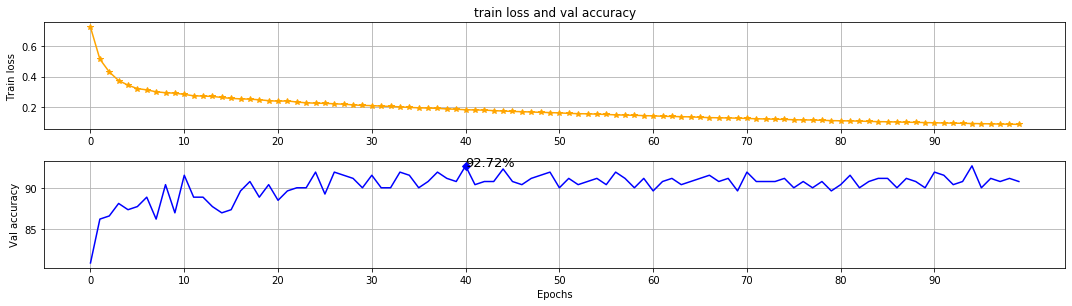

Finished Training


In [0]:
# Train the network
n_batches = 32
EPOCHS = 100

for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i in range(int(train_feature.shape[0]/n_batches)+1):
        # Local batches and labels
        if (i+1)*n_batches > train_feature.shape[0]:
            inputs, labels = train_feature[i*n_batches:,:], train_label[i*n_batches:]
        else:
            inputs, labels = train_feature[i*n_batches:(i+1)*n_batches,:], train_label[i*n_batches:(i+1)*n_batches]

        inputs = torch.from_numpy(inputs)
        # print(inputs.shape)
        labels = torch.from_numpy(np.array(labels))

        if IS_GPU:
            inputs = inputs.cuda()
            labels = labels.cuda()

        # wrap them in Variable
        inputs = Variable((inputs))
        labels = Variable(((labels)))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # inputs = torch.unsqueeze(inputs,1)
        outputs = net(inputs.float())
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    
    # Normalizing the loss by the total number of train batches
    running_loss/=int(train_feature.shape[0]/n_batches)+1
    print('[%d] loss: %.3f' %
          (epoch + 1, running_loss))

    # Scale of 0.0 to 100.0
    # Calculate validation set accuracy of the existing model
    val_accuracy, val_classwise_accuracy = \
        calculate_val_accuracy(IS_GPU)
    print('Accuracy of the network on the val images: %d %%' % (val_accuracy))

    train_loss_over_epochs.append(running_loss)
    val_accuracy_over_epochs.append(val_accuracy)



f, axes = plt.subplots(2, 1, figsize=(15,4))
f.tight_layout()
# plt.subplot(2, 1, 1)
axes[0].set_ylabel('Train loss')
axes[0].plot(np.arange(EPOCHS), train_loss_over_epochs, '-*', color='orange')
axes[0].set_title('train loss and val accuracy')
axes[0].set_xticks(np.arange(EPOCHS, dtype=int, step=10))
axes[0].grid(True)
axes[0].figure.savefig("loss.png")

acc_lst = [x.item() for x in val_accuracy_over_epochs]
max_idx = np.argmax(acc_lst)
# plt.subplot(2, 1, 2, figsize=(20,4))
markers_on = [max_idx]
axes[1].autoscale(axis='y')
axes[1].plot(np.arange(EPOCHS), val_accuracy_over_epochs, '-bD', markevery=markers_on)
axes[1].text(max_idx, val_accuracy_over_epochs[max_idx].item(), str(format(val_accuracy_over_epochs[max_idx].item(), ".2f")+"%"), fontsize=13)
axes[1].set_ylabel('Val accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_xticks(np.arange(EPOCHS, dtype=int, step=10))
axes[1].grid(True)
axes[1].figure.savefig("accuracy.png")
# axes[1].close(fig)
plt.show()
print('Finished Training')
# -------------

class_accuracy [tensor(92., device='cuda:0') tensor(98.2456, device='cuda:0')
 tensor(97.0149, device='cuda:0') tensor(95.1613, device='cuda:0')]
accuracy 0.9540229885057471
C [[69.  0.  0.  2.]
 [ 1. 56.  2.  1.]
 [ 1.  0. 65.  0.]
 [ 4.  1.  0. 59.]]


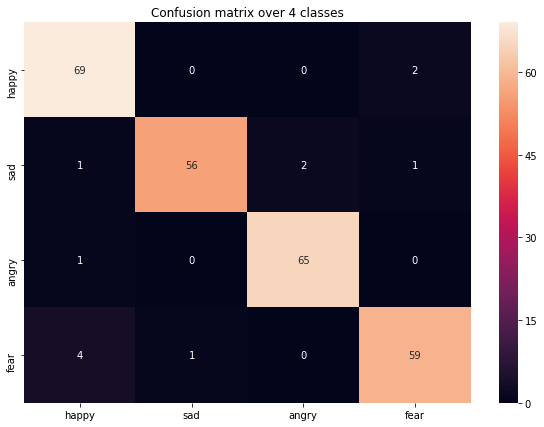

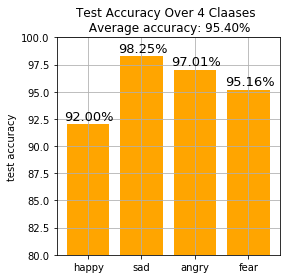

In [0]:

net.eval()

total = 0
predictions = []
n_batches = 32
# for i in range(test_feature.shape[0]):
correct = 0.
total = 0.
predictions = []
TOTAL_CLASSES = 4
class_correct = list(0. for i in range(TOTAL_CLASSES))
class_total = list(0. for i in range(TOTAL_CLASSES))

for i in range(int(test_feature.shape[0]/n_batches)+1):
  # Local batches and labels
  if (i+1)*n_batches > test_feature.shape[0]:
      testData, labels = test_feature[i*n_batches:,:], test_label[i*n_batches:]
  else:
      testData, labels = test_feature[i*n_batches:(i+1)*n_batches,:], test_label[i*n_batches:(i+1)*n_batches]

  # testData, label = test_feature, test_label

  testData = torch.from_numpy(testData)
  labels = torch.from_numpy(np.array(labels))

  if IS_GPU:
    testData = testData.cuda()
    labels = labels.cuda()

  testData = Variable(testData)
  outputs = net(testData.float())
  _, predicted = torch.max(outputs.data, 1)
  predictions.extend(list(predicted.cpu().numpy()))
  # total += label.size(0)

  correct += (predicted == labels).sum()
  c = (predicted == labels).squeeze()
  for i in range(len(labels)):
      label = labels[i]
      class_correct[label] += c[i]
      class_total[label] += 1

acc = 0
for l_i, label in enumerate(predictions):
    if label == test_label[l_i]:
        acc += 1
    # print([str(l_i), str(label)], test_label[l_i])
class_accuracy = 100 * np.divide(class_correct, class_total)
print("class_accuracy", class_accuracy)
print("accuracy", acc/len(test_label))

C = np.histogram2d(predictions, test_label, bins=4)[0]
print("C", C)
my_xticks = ['happy','sad','angry','fear']

df_cm = pd.DataFrame(C, index=[i for i in my_xticks], columns=[i for i in my_xticks])
plt.figure(figsize = (10,7))
plt.title("Confusion matrix over 4 classes")
sn.heatmap(df_cm, annot=True)

f, ax = plt.subplots(figsize=(4,4))
x = np.arange(1,5)
idx = np.array([0,1,2,3])
ax.set_xticks(x)
ax.set_xticklabels(my_xticks)
for i in range(4):
  ax.text(i+0.56, class_accuracy[i].item()+0.4, str(format(class_accuracy[i].item(), ".2f")+"%"), fontsize=13)
ax.bar(x, class_accuracy, color='orange')
ax.set_ylim(bottom=80, top=100)
ax.set_ylabel('test accuracy')
ax.set_title('Test Accuracy Over 4 Claases \n Average accuracy: ' + str(format(acc/len(test_label),".2%")))
ax.grid(True)
ax.figure.savefig("test_acc.png")
plt.show()